# Validation
- Load a separately generated validation dataset-
- Introduce PO Box errors
- Prepare dataset 
- Run the final adaboost model and evaluate performance


In [1]:
import pandas as pd
import numpy as np
import jellyfish
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import pickle
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
# A function to create a formatted confusion matrix for each model
def pretty_confusion(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt=',', cbar=False); 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix\nF1 Score: ' + str(f1_score(y_test, preds))); 
    ax.xaxis.set_ticklabels(['non-match', 'match']); ax.yaxis.set_ticklabels(['match', 'non-match'])

In [3]:
col = ['id', 'nationality', 'gender', 'age', 'dob', 'title',
       'first_name', 'last_name', 'state', 'city', 'zip',
       'street_number', 'address_1', 'address_2', 'phone', 'SSN', 'blk', 'family']
df = pd.read_csv('validationData.csv', encoding = 'latin1', header=0 , names = col)
df.head()

,id,nationality,gender,age,dob,title,first_name,last_name,state,city,zip,street_number,address_1,address_2,phone,SSN,blk,family
0,rec-4991-dup-1,tha,f,20,19980201,,joshja,tantasatityanon,ss,rouse hill,4227,1,galleghancircuit,,07 87400390,7459676,3,NoRole
1,rec-5630-org,ara,m,22,19961027,dr,dale,alesha,vic,wallan,2120,110,henty street,,618 09478814,1028327,0,NoRole
2,rec-9215-org,eng,f,38,19800417,,william,walmsley,nsw,bingara,2198,257,bacchus circuit,diamond star,02 21066595,4973766,6,NoRole
3,rec-4534-org,ina,f,33,19850401,,harvey,gunawan,qld,mount byron,2287,51,coles place,arcadia,08 27763692,5433846,1,NoRole
4,rec-4605-org,eng,f,,19360607,,aimee,sackville,nsw,auburn,3131,150,carnegie crescent,,2 87352062,2761868,7,NoRole


In [4]:
for i in df.sample(frac=.02).index:
    df['address_1'].iloc[i] = 'P.O. Box ' + str(np.random.randint(1, 2000))

/home/aind2/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)



After loading the dataset, several additional features are calculated including phonetic representations of first name, last name, and city.  These were created using the metaphone algorithm available in the jellyfish package

Data is into 2 dataframes by originals and duplicates.

In [5]:
df[['prefix','trueRecordID', 'OrgDup', 'seqNum']] = df.id.str.split('-', expand=True)
df.drop('prefix', axis=1, inplace=True)
df.fillna ('', inplace=True)

df['stringConcat'] = df.title+df.first_name+df.last_name+df.city+df.state+df.zip+df.address_1+df.address_2+df.phone

df['last_name_met'] = df['last_name'].str.replace(' ', '').apply(lambda x: jellyfish.metaphone(x))
df['first_name_met'] = df['first_name'].str.replace(' ', '').apply(lambda x: jellyfish.metaphone(x))
df['city_met'] = df['city'].str.replace(' ', '').apply(lambda x: jellyfish.metaphone(x))
df['phone'] = df['phone'].str.replace(' ', '')
df['predicateLastName'] = df['last_name'].str[:2]
df['predicateFirstName'] = df['first_name'].str[:2]


dfDup = df[df.OrgDup == 'dup']
dfOrg = df[df.OrgDup == 'org']
dfDup.columns = [str(col) + '_match' for col in dfDup.columns]
dfOrg.columns = [str(col) + '_org' for col in dfOrg.columns]
print('Original Recordset:', dfOrg.shape)
print('Recordset of matches:', dfDup.shape)

Original Recordset: (10000, 27)
Recordset of matches: (5000, 27)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct

In [7]:
def ngrams(string, n=4):
    string = re.sub(r'[,-./]|\s',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

def awesome_cossim_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))


In [8]:
t3 = time()

dfConcatStrings_org = dfOrg.stringConcat_org
dfConcatStrings_match = dfDup.stringConcat_match
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
vectorizer.fit(df.stringConcat)
tf_idf_matrix_org = vectorizer.transform(dfConcatStrings_org)
tf_idf_matrix_match = vectorizer.transform(dfConcatStrings_match)

matches = awesome_cossim_top(tf_idf_matrix_org, tf_idf_matrix_match.transpose(), 10, 0.1)

/home/aind2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [9]:
dfBlockedMatches = pd.DataFrame(np.column_stack(matches.nonzero()), columns = ['OriginalIndex', 'MatchIndex'])
dfBlockedMatches['similarity'] = matches.data
dfBlockedMatches = dfBlockedMatches.merge(dfOrg.reset_index(), left_on = 'OriginalIndex', right_index=True )
dfBlockedMatches = dfBlockedMatches.merge(dfDup.reset_index(), left_on = 'MatchIndex', right_index=True )

In [10]:
dfBlockedMatches.drop_duplicates(subset=['id_org', 'id_match'], inplace=True) 
dfBlockedMatches['MATCH'] = np.where(dfBlockedMatches[
        'trueRecordID_match']==dfBlockedMatches['trueRecordID_org'], 1, 0)


t4 = time()
time_TFIDF_Blocking = t4-t3

## How many of the 15,000 matches have we included in the dataset?
truePos_TfIdf = sum(dfBlockedMatches.MATCH)


print('TF-IDF Blocking result shape:', dfBlockedMatches.shape)
print('TF-IDF Blocking time:',time_TFIDF_Blocking)
print('TF-IDF Blocking true positives included:',truePos_TfIdf)

TF-IDF Blocking result shape: (29334, 60)
TF-IDF Blocking time: 2.1243584156036377
TF-IDF Blocking true positives included: 4999


In [11]:
dfBlockedMatches['phone_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['phone_org'], x['phone_match']), axis=1)
dfBlockedMatches['last_name_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['last_name_org'], x['last_name_match']), axis=1)
dfBlockedMatches['first_name_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['first_name_org'], x['first_name_match']), axis=1)
dfBlockedMatches['city_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['city_org'], x['city_match']), axis=1)
dfBlockedMatches['state_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['state_org'], x['state_match']), axis=1)
dfBlockedMatches['address_1_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['address_1_org'], x['address_1_match']), axis=1)
dfBlockedMatches['address_1_2_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['address_1_org'], x['address_2_match']), axis=1)
dfBlockedMatches['dob_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['dob_org'], x['dob_match']), axis=1)
dfBlockedMatches['zip_dlev'] = dfBlockedMatches.apply(lambda x: jellyfish.damerau_levenshtein_distance
                                                        (x['zip_org'], x['zip_match']), axis=1)

In [12]:
def scale_invert(x):
    scaled = 1-(x/10)
    return max(0, scaled)

In [13]:
dfBlockedMatches['phone_scaled'] = dfBlockedMatches['phone_dlev'].apply(scale_invert)
dfBlockedMatches['last_name_scaled'] = dfBlockedMatches['last_name_dlev'].apply(scale_invert)
dfBlockedMatches['first_name_scaled'] = dfBlockedMatches['first_name_dlev'].apply(scale_invert)
dfBlockedMatches['city_scaled'] = dfBlockedMatches['city_dlev'].apply(scale_invert)
dfBlockedMatches['state_scaled'] = dfBlockedMatches['state_dlev'].apply(scale_invert)
dfBlockedMatches['address_1_scaled'] = dfBlockedMatches['address_1_dlev'].apply(scale_invert)
dfBlockedMatches['address_1_2_scaled'] = dfBlockedMatches['address_1_2_dlev'].apply(scale_invert)
dfBlockedMatches['dob_scaled'] = dfBlockedMatches['dob_dlev'].apply(scale_invert)
dfBlockedMatches['zip_scaled'] = dfBlockedMatches['zip_dlev'].apply(scale_invert)

In [14]:
dfFeatures = dfBlockedMatches[[ 'id_org', 'id_match', 'MATCH',
       'phone_scaled', 'last_name_scaled', 'first_name_scaled', 'city_scaled',
       'state_scaled', 'address_1_scaled', 'address_1_2_scaled', 'dob_scaled',
       'zip_scaled', 'similarity']]
dfFeatures.to_csv('dfFeatures.csv')
#dfFeatures.sample(n=10000).to_csv('dfFeatures_sample.csv')

In [15]:
X = dfFeatures[['phone_scaled'
                , 'last_name_scaled'
                , 'first_name_scaled'
                , 'city_scaled'
                , 'address_1_scaled'
                , 'dob_scaled'
                , 'zip_scaled'
                , 'similarity']]
y = dfFeatures['MATCH'] 

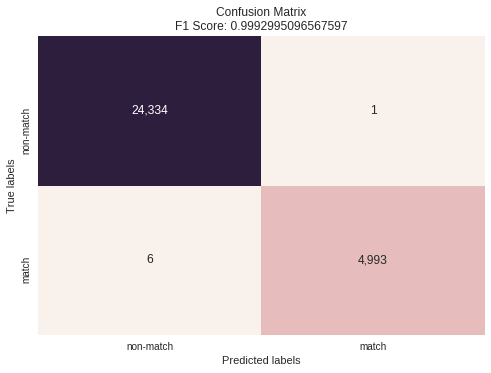

In [16]:
best_ada = pickle.load(open('best_ada.pkl', 'rb'))
preds = best_ada.predict(X)
pretty_confusion(y, preds)

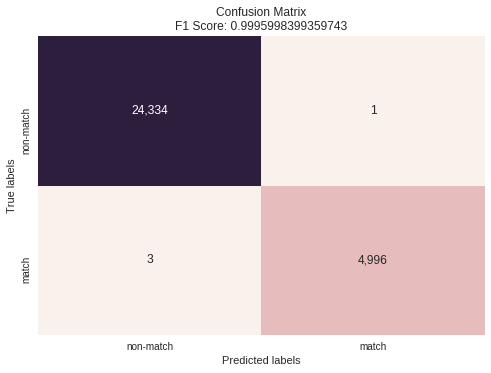

In [17]:
ada = pickle.load(open('ada.pkl', 'rb'))
preds = ada.predict(X)
pretty_confusion(y, preds)

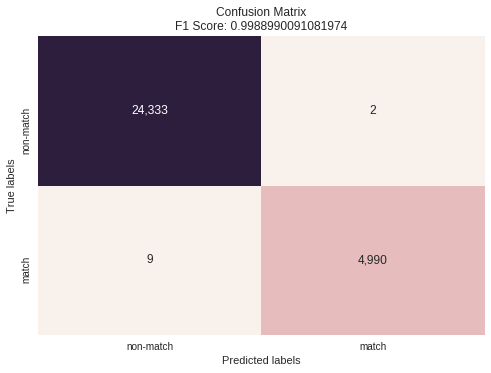

In [18]:
gnb = pickle.load(open('gnb.pkl', 'rb'))
preds = gnb.predict(X)
pretty_confusion(y, preds)

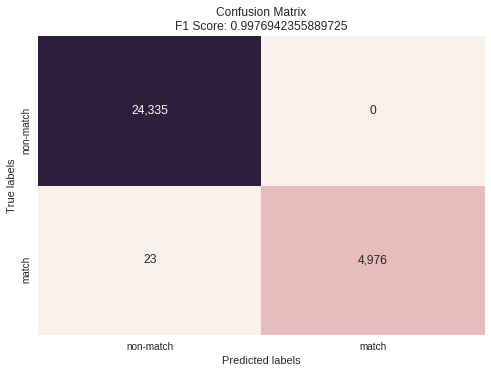

In [19]:
lr = pickle.load(open('lr.pkl', 'rb'))
preds = lr.predict(X)
pretty_confusion(y, preds)

In [20]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}